SpM $\omega$
=============

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import sys
sys.path.append("../../admmsolver/src/")

In [4]:
from admmsolver.objectivefunc import ConstrainedLeastSquares, L2Regularizer, SemiPositiveDefinitePenalty
from admmsolver.optimizer import SimpleOptimizer, Problem
from admmsolver.matrix import identity, DiagonalMatrix
from admmsolver.util import smooth_regularizer_coeff
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from itertools import product

import irbasis3

In [5]:
wmax = 10.0
beta = 100.0
lambda_ = wmax * beta
K = irbasis3.KernelFFlat(lambda_)
basis = irbasis3.FiniteTempBasis(K, "F", beta, eps=1e-7)

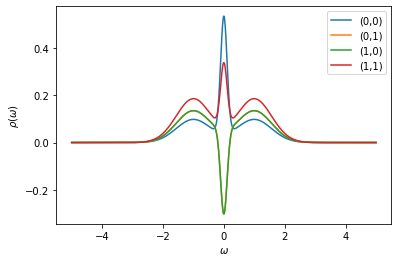

In [6]:
gaussian = lambda x, mu, sigma: np.exp(-((x-mu)/sigma)**2)/(np.sqrt(np.pi)*sigma)

theta = 0.2*np.pi
nflavors = 2
rot_mat = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

def rho(omega):
    rho_omega = np.zeros((omega.size, 2, 2))
    rho_omega[:,0,0] = 0.2*gaussian(omega, 0.0, 0.15)
    rho_omega[:,1,1] = 0.4*gaussian(omega, 1.0, 0.8) + 0.4*gaussian(omega, -1.0, 0.8)
    return np.einsum('ji,wjk,kl->wil', rot_mat, rho_omega, rot_mat)

omegas = np.linspace(-5, 5, 1000)
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\rho(\omega)$')
rho_omega = rho(omegas)
for i, j in product(range(2),repeat=2):
    plt.plot(omegas, rho_omega[:,i,j], label=f'({i},{j})')
plt.legend()

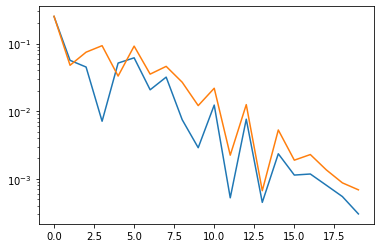

In [7]:
# Expand the spectral function in IR
from numpy.polynomial.legendre import leggauss

def scale_quad(x, w, xmin, xmax):
    """ Scale weights and notes of quadrature to the interval [xmin, xmax] """
    assert xmin < xmax
    dx = xmax - xmin
    w_ = 0.5 * dx * w
    x_ = (0.5 * dx) * (x + 1) + xmin
    return x_, w_

x_, w_ = leggauss(10000)
x, w = scale_quad(x_, w_, -wmax, wmax)
all_l = np.arange(basis.s.size)

rhol = np.einsum("lw,w,wij->lij", basis.v.value(all_l[:,None], x[None,:]), w, rho(x), optimize=True)
gl = - basis.s[:,None,None] * rhol

plt.semilogy(np.abs(rhol[::2,0,0]))
plt.semilogy(np.abs(rhol[::2,1,1]))

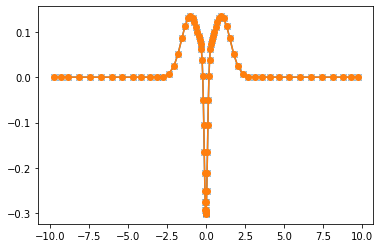

In [8]:
# Sampling points in the real-frequency space
def __oversample(x):
    xmid = 0.5*(x[1:] + x[:-1])
    return np.unique(np.hstack((x, xmid)))

def _oversample(x, n=1):
    for i in range(n):
        x = __oversample(x)
    return x

smpl_w = _oversample(basis.v[-1].roots(), 1)
prj_w = basis.v(smpl_w).T

plt.plot(smpl_w, rho(smpl_w)[:,0,1], marker="x")
plt.plot(smpl_w, prj_w @ rhol[:,0,1], marker="o")

In [9]:
# Sum rule (from rhol)
prj_sum = basis.s * (basis.u(0) + basis.u(beta))
prj_sum = prj_sum.reshape((1,-1))
print(prj_sum.shape)
mom = np.einsum('xw,wij->ij', prj_sum, rhol)
mom

(1, 40)


array([[0.4072949 , 0.28531695],
       [0.28531695, 0.5927051 ]])

In [10]:
# Projector from sampled values to rho_l
prj_w_to_l = np.zeros((basis.size, smpl_w.size))

x_, w_ = leggauss(10)

for s in range(smpl_w.size-1):
    x, w = scale_quad(x_, w_, smpl_w[s], smpl_w[s+1])
    dx = smpl_w[s+1] - smpl_w[s]
    f = (x - smpl_w[s])/dx
    g = (smpl_w[s+1] - x)/dx
    for l in range(basis.size):
        prj_w_to_l[l, s+1] += np.sum(w * basis.v[l](x) * f)
        prj_w_to_l[l, s] += np.sum(w * basis.v[l](x) * g)

print("cond: ", np.linalg.cond(prj_w_to_l))

cond:  7.769177326018083


In [11]:
# w to l to sum
prj_sum_from_w = prj_sum @ prj_w_to_l
print(prj_sum_from_w.shape)
print(np.einsum("xw,wij->ij", prj_sum_from_w, rho(smpl_w)))

(1, 77)
[[0.40884587 0.28610395]
 [0.28610395 0.59476749]]


In [17]:
# rho_l = argmin_{x} |- s_l * x_l + g_l|_2^2 + alpha * |x|_1
alpha = 1e-10
noise = 1e-8
gl_dirty = gl + noise * np.random.randn(basis.size, nflavors, nflavors)
gl_dirty = gl_dirty.ravel()

Aw = - basis.s[:,None] * prj_w_to_l
A = np.einsum("lw,ij->liwj", Aw, np.identity(nflavors**2)).reshape(Aw.shape[0]*nflavors**2, Aw.shape[1]*nflavors**2)
V = np.einsum("xw,ij->xiwj", prj_sum_from_w, np.identity(nflavors**2))
V = V.reshape(nflavors**2, prj_sum_from_w.shape[1]*nflavors**2)
smooth_prj = np.einsum("Ww,ij->Wiwj", smooth_regularizer_coeff(smpl_w), np.identity(nflavors**2)).\
      reshape(-1, smpl_w.size * nflavors**2)

lstsq = ConstrainedLeastSquares(
          1.0, A, gl_dirty,
          V, mom.ravel()
      )
l2 = L2Regularizer(alpha, smooth_prj)
nn = SemiPositiveDefinitePenalty((smpl_w.size, nflavors, nflavors), 0)

equality_conditions = [
      (0, 1, identity(smpl_w.size*nflavors**2), identity(smpl_w.size*nflavors**2)),
      (0, 2, identity(smpl_w.size*nflavors**2), identity(smpl_w.size*nflavors**2)),
]
problem = Problem([lstsq, l2, nn], equality_conditions)

In [18]:
x0 = None
opt = SimpleOptimizer(problem, x0=x0, mu=0.1)
opt.solve(10000)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 308 is different from 77)

In [21]:
rho_w_reconst = opt.x[0].reshape((-1, nflavors, nflavors))

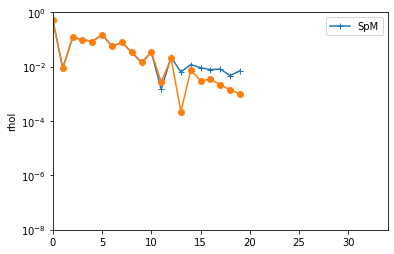

In [ ]:
plt.semilogy(np.abs((prj_w_to_l@opt.x[0])[::2].real), marker="+", label="SpM")
plt.semilogy(np.abs(rhol[::2]), marker="o")
plt.xlim([0,34])
plt.ylim([1e-8,1])
plt.ylabel("rhol")
plt.legend()

/opt/homebrew/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


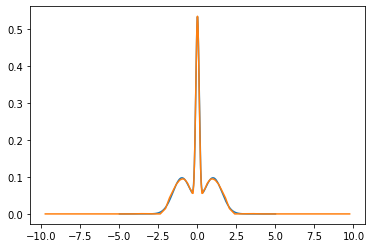

In [22]:
plt.plot(omegas, rho(omegas)[:,0,0])
plt.plot(smpl_w, rho_w_reconst[:,0,0])

/opt/homebrew/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


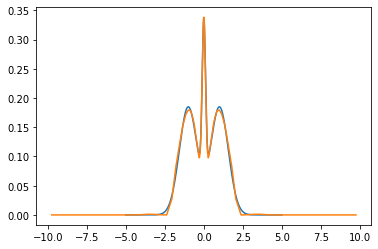

In [23]:
plt.plot(omegas, rho(omegas)[:,1,1])
plt.plot(smpl_w, rho_w_reconst[:,1,1])

/opt/homebrew/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


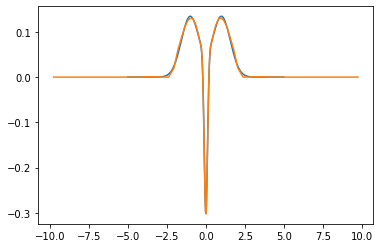

In [24]:
plt.plot(omegas, rho(omegas)[:,0,1])
plt.plot(smpl_w, rho_w_reconst[:,0,1])

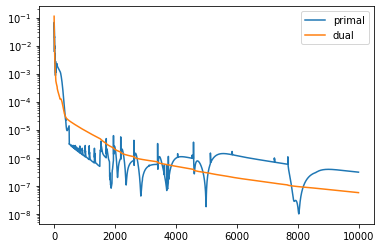

In [25]:
plt.semilogy(opt._primal_residual, label="primal")
plt.semilogy(opt._dual_residual, label="dual")
plt.legend()